In [1]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)


c:\Users\PX\Master\διπλωμαιτκ\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\PX\Master\διπλωμαιτκ\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
import sys
sys.path.append('../dataset')
import get_funsd


In [3]:
funsd = get_funsd.CustomFunsdDataset('../dataset/')
funsd.split_generators()

In [4]:
funsd

CustomFunsdDataset:
DatasetDict({
    train: Dataset({features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags','line_ids','linkings','image','image_name'], num_rows: 149}),
    test: Dataset({features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags','line_ids','linkings','image','image_name'], num_rows: 50})
})

In [5]:
label_map = {
    0: 'O',
    1: 'B-HEADER',
    2: 'I-HEADER',
    3: 'B-QUESTION',
    4: 'I-QUESTION',
    5: 'B-ANSWER', 
    6: 'I-ANSWER'}

In [6]:
funsd['train'][0].keys()

dict_keys(['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags', 'line_ids', 'linkings', 'image', 'image_name'])

In [7]:
from datasets import Dataset, DatasetDict

funsd_train_dataset = Dataset.from_dict({
    "id": [entry["id"] for entry in funsd["train"]],
    "tokens": [entry["tokens"] for entry in funsd["train"]],
    "ner_boxes": [entry["ner_boxes"] for entry in funsd["train"]],
    "bboxes": [entry["bboxes"] for entry in funsd["train"]],
    "ner_tags": [entry["ner_tags"] for entry in funsd["train"]],
    "line_ids": [entry["line_ids"] for entry in funsd["train"]],
    "linkings": [entry["linkings"] for entry in funsd["train"]],
    "image": [entry["image"] for entry in funsd["train"]],
    "image_name": [entry["image_name"] for entry in funsd["train"]],
})

funsd_test_dataset = Dataset.from_dict({
    "id": [entry["id"] for entry in funsd["test"]],
    "tokens": [entry["tokens"] for entry in funsd["test"]],
    "ner_boxes": [entry["ner_boxes"] for entry in funsd["test"]],
    "bboxes": [entry["bboxes"] for entry in funsd["test"]],
    "ner_tags": [entry["ner_tags"] for entry in funsd["test"]],
    "line_ids": [entry["line_ids"] for entry in funsd["test"]],
    "linkings": [entry["linkings"] for entry in funsd["test"]],
    "image": [entry["image"] for entry in funsd["test"]],
    "image_name": [entry["image_name"] for entry in funsd["test"]],
})

# Optionally, you can create a DatasetDict if you have train/test splits
dataset = DatasetDict({
    "train": funsd_train_dataset,
    'test': funsd_test_dataset
})


In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags', 'line_ids', 'linkings', 'image', 'image_name'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags', 'line_ids', 'linkings', 'image', 'image_name'],
        num_rows: 50
    })
})

In [181]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [182]:
import numpy as np
def make_dataset(documents):
    images = documents['image']
    
    rgb_images = list(map(lambda img: img.convert('RGB'), images))
    words = documents['tokens']
    boxes = documents['bboxes']
    word_labels = documents['ner_tags']

    encoding = processor(rgb_images, words, boxes=boxes, word_labels=word_labels,
                         truncation=True, padding="max_length", return_offsets_mapping=True).to(device)
    encoding.pop('offset_mapping')

    # Ensure that the encoding contains the expected keys
    return encoding

In [185]:
cols = funsd_train_dataset.column_names

In [153]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})
train_dataset = dataset["train"].map(
    make_dataset,
    batched=True,
    remove_columns = cols,
    features=features)

Map: 100%|██████████| 149/149 [00:02<00:00, 61.34 examples/s]


In [154]:
test_dataset = dataset["test"].map(
    make_dataset,
    batched=True,
    remove_columns = cols,
    features=features)

Map: 100%|██████████| 50/50 [00:01<00:00, 31.00 examples/s]


In [171]:
print(processor.tokenizer.decode(train_dataset[0]["input_ids"]))

<s> R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity . ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip . wp</s><pad><pad><pad><pad><pad><pad><pad><

In [157]:
train_dataset.set_format("torch")

In [158]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)


pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [174]:
c=0
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())
  c+=1
  if c>10:break

<s> -100
 R 0
& -100
D -100
 : 3
 Suggest 3
ion -100
: -100
 Date 3
: -100
 License 5


In [160]:
from evaluate import load 
metric = load("seqeval")  # Replace with the actual metric name


In [18]:
label_list = ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']

In [161]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [162]:
label_map_reversed = {v: k for k, v in label_map.items()} 


In [186]:

from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=label_map,
                                                         label2id=label_map_reversed).to(device)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [177]:

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="laoutlm3_output",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-4,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [178]:
from transformers.data.data_collator import default_data_collator

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [179]:
trainer.train()


  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\PX\Master\διπλωμαιτκ\venv\Lib\site-packages\transformers\modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 20%|██        | 4/20 [00:53<03:14, 12.18s/it]

KeyboardInterrupt: 

In [163]:
trainer.evaluate()


c:\Users\PX\Master\διπλωμαιτκ\venv\Lib\site-packages\transformers\modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 25/25 [01:12<00:00,  2.92s/it]


{'eval_loss': 0.7255235910415649,
 'eval_precision': 0.757934628138323,
 'eval_recall': 0.7948335817188277,
 'eval_f1': 0.7759456838021338,
 'eval_accuracy': 0.7985260905741115,
 'eval_runtime': 76.4939,
 'eval_samples_per_second': 0.654,
 'eval_steps_per_second': 0.327,
 'epoch': 1.3333333333333333}

In [41]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(".\laoutlm3_output/checkpoint-100")

In [164]:
example.keys()

dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'])

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 50
})

In [165]:

example = funsd_test_dataset[1]
image = example["image"].convert("RGB")
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels,return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 293])
attention_mask torch.Size([1, 293])
bbox torch.Size([1, 293, 4])
labels torch.Size([1, 293])
pixel_values torch.Size([1, 3, 224, 224])


In [166]:
import torch
with torch.no_grad():
  outputs = model(**encoding)

In [167]:
logits = outputs.logits
logits.shape

torch.Size([1, 293, 7])

In [168]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)
len(predictions)

[0, 3, 4, 3, 4, 5, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 3, 3, 4, 3, 4, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 5, 6, 6, 3, 4, 4, 4, 4, 4, 5, 6, 3, 4, 4, 4, 5, 5, 6, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 6, 6, 5, 6, 6, 5, 6, 6, 6, 5, 6, 6, 5, 6, 5, 6, 5, 6, 5, 6, 6, 5, 6, 6, 5, 6, 6, 5, 6, 6, 5, 6, 6, 5, 6, 6, 5, 6, 6, 0, 0, 0, 0, 0, 0]


293

In [170]:
labels = encoding.labels.squeeze().tolist()
print(labels)
len(labels)

[-100, 3, -100, 3, -100, 5, 3, -100, -100, 1, -100, -100, -100, 3, -100, -100, -100, 3, -100, -100, -100, 3, -100, -100, -100, 3, -100, -100, 3, -100, -100, -100, 3, -100, -100, -100, 3, -100, -100, -100, 5, 5, 5, 5, 5, 5, 5, 0, -100, -100, -100, 0, -100, 0, -100, 0, 0, -100, 0, 0, -100, 0, -100, 0, 1, -100, -100, -100, 2, -100, 0, 0, 0, -100, 5, -100, 6, -100, 6, 5, -100, 6, -100, 6, -100, -100, 0, -100, 0, 0, -100, -100, -100, 0, -100, 0, 0, -100, -100, 0, -100, 0, -100, -100, 0, -100, -100, 0, 3, -100, 4, 3, -100, 4, 3, 4, 3, -100, 4, 5, -100, -100, 6, 6, -100, 6, -100, 6, -100, 6, 6, -100, -100, 6, -100, -100, 6, -100, -100, 5, 6, 6, -100, -100, 6, 5, 6, 6, -100, -100, 6, -100, 6, 5, 6, 6, -100, -100, 6, 5, 6, 6, 6, -100, -100, 6, 5, 6, 6, 6, -100, -100, 6, 5, 6, 6, -100, -100, 6, 0, 0, -100, -100, 0, 0, -100, -100, 0, -100, -100, -100, -100, 0, -100, 0, 0, -100, 0, -100, 0, 0, -100, -100, 0, -100, -100, 0, 0, -100, 0, 0, -100, -100, -100, 0, -100, 0, 0, -100, -100, 0, -100, 0, -10

293

In [118]:
true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]

token_boxes = encoding.bbox.squeeze().tolist()

true_boxes = [box for box, label in zip(token_boxes, labels) if label != -100]


In [129]:
example['tokens'][-1] , true_predictions[-1]

('Pages', 'O')

In [132]:
len(example['tokens']), len(true_predictions) , len(true_labels)

(167, 168, 168)

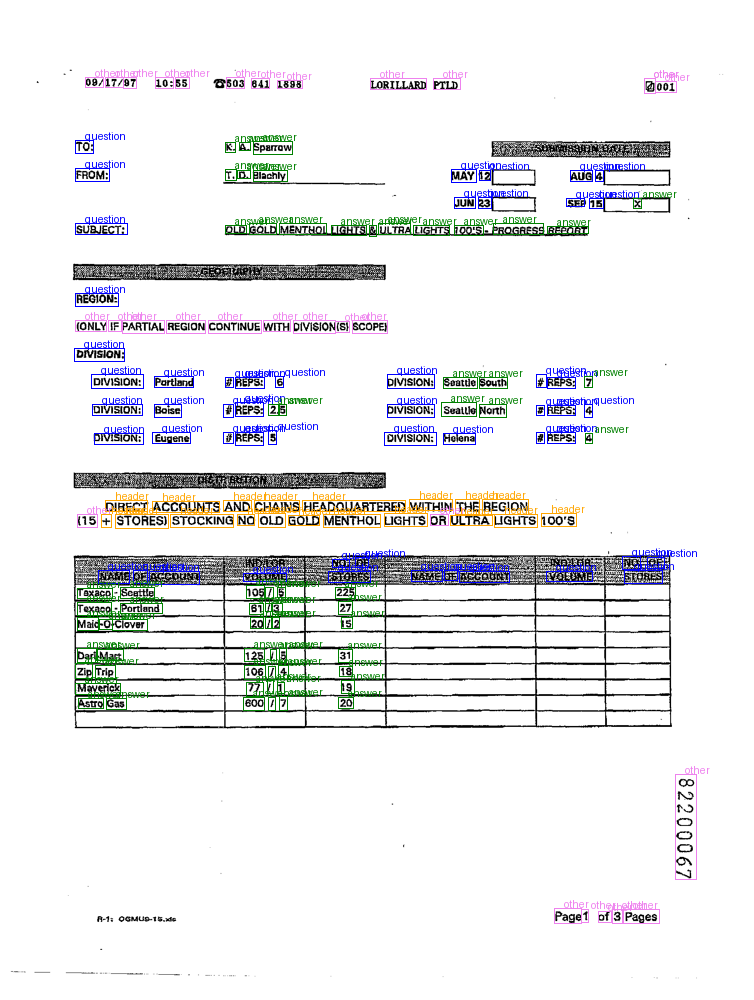

In [120]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions,true_boxes ):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

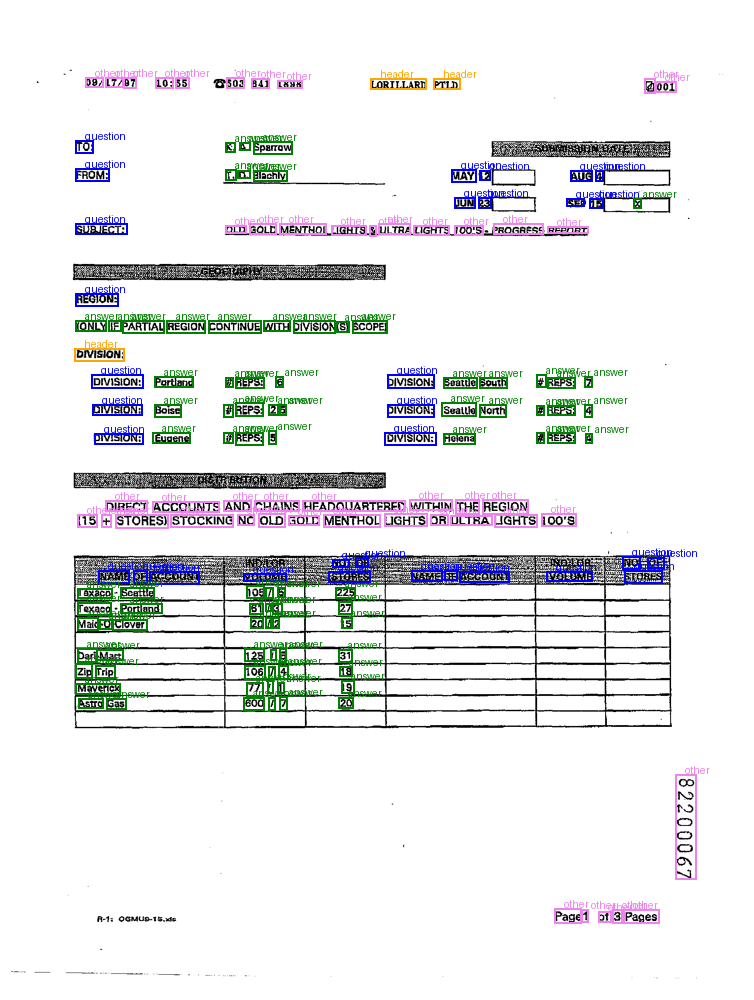

In [136]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(label_map[label]).lower()
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

In [32]:
### put an image from epant !!!!!!!!!!!!!!!!!!!!!!!!!!!!!